In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(RColorBrewer)

Some relevant colums in the dataset:

1. PassengerId: Unique identifier for passengers
2. Survived: (1:Survived, 0:Passed)
3. Pclass: class number (1,2,3)
4. Name: Passenger name
5. Sex: Male or Female
6. Age: Age in years
7. SibSp: Number of siblings / spouses aboard
8. Parch: Number of parents / children aboard
9. Ticket: Ticket number
10. Fare: Passenger fare
11. Cabin: Cabin number
12. Embarked: Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)

In [112]:
# Wragling Data Set
titanic <- read_csv("train.csv") %>% 
    mutate(Survived = as_factor(Survived)) %>%
    filter(!is.na(Age)) %>%
    filter(!is.na(Cabin))
glimpse(titanic)

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Survived = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)



Rows: 185
Columns: 12
$ PassengerId <dbl> 2, 4, 7, 11, 12, 22, 24, 28, 53, 55, 62, 63, 67, 76, 89, …
$ Survived    <fct> 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, …
$ Pclass      <dbl> 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, …
$ Name        <chr> "Cumings, Mrs. John Bradley (Florence Briggs Thayer)", "F…
$ Sex         <chr> "female", "female", "male", "female", "female", "male", "…
$ Age         <dbl> 38.0, 35.0, 54.0, 4.0, 58.0, 34.0, 28.0, 19.0, 49.0, 65.0…
$ SibSp       <dbl> 1, 1, 0, 1, 0, 0, 0, 3, 1, 0, 0, 1, 0, 0, 3, 1, 0, 0, 0, …
$ Parch       <dbl> 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, …
$ Ticket      <chr> "PC 17599", "113803", "17463", "PP 9549", "113783", "2486…
$ Fare        <dbl> 71.2833, 53.1000, 51.8625, 16.7000, 26.5500, 13.0000, 35.…
$ Cabin       <chr> "C85", "C123", "E46", "G6", "C103", "D56", "A6", "C23 C25…
$ Embarked    <chr> "C", "S", "S", "S", "S", "S", "S", "S", "C", "C", NA, "S"…


In [113]:
set.seed(1)
heart_split <- initial_split(titanic, prop = 0.75, strata = Survived)
titanic_train <- training(heart_split)
titanic_test <- testing(heart_split)

In [114]:
# summarize dataset
set.seed(1)
num_obs <- nrow(titanic_train)

titanic_sum <- titanic_train %>%
    group_by(Survived) %>%
    summarize(count = n(), 
              percentage = n()/ num_obs* 100)
titanic_sum

summary(titanic_train)

`summarise()` ungrouping output (override with `.groups` argument)



Survived,count,percentage
<fct>,<int>,<dbl>
0,45,32.3741
1,94,67.6259


  PassengerId    Survived     Pclass         Name               Sex           
 Min.   :  2.0   0:45     Min.   :1.00   Length:139         Length:139        
 1st Qu.:238.5   1:94     1st Qu.:1.00   Class :character   Class :character  
 Median :436.0            Median :1.00   Mode  :character   Mode  :character  
 Mean   :435.6            Mean   :1.18                                        
 3rd Qu.:645.0            3rd Qu.:1.00                                        
 Max.   :888.0            Max.   :3.00                                        
      Age            SibSp            Parch           Ticket         
 Min.   : 0.92   Min.   :0.0000   Min.   :0.0000   Length:139        
 1st Qu.:24.00   1st Qu.:0.0000   1st Qu.:0.0000   Class :character  
 Median :35.00   Median :0.0000   Median :0.0000   Mode  :character  
 Mean   :35.80   Mean   :0.4245   Mean   :0.4173                     
 3rd Qu.:47.00   3rd Qu.:1.0000   3rd Qu.:1.0000                     
 Max.   :80.00   Max.   :3.

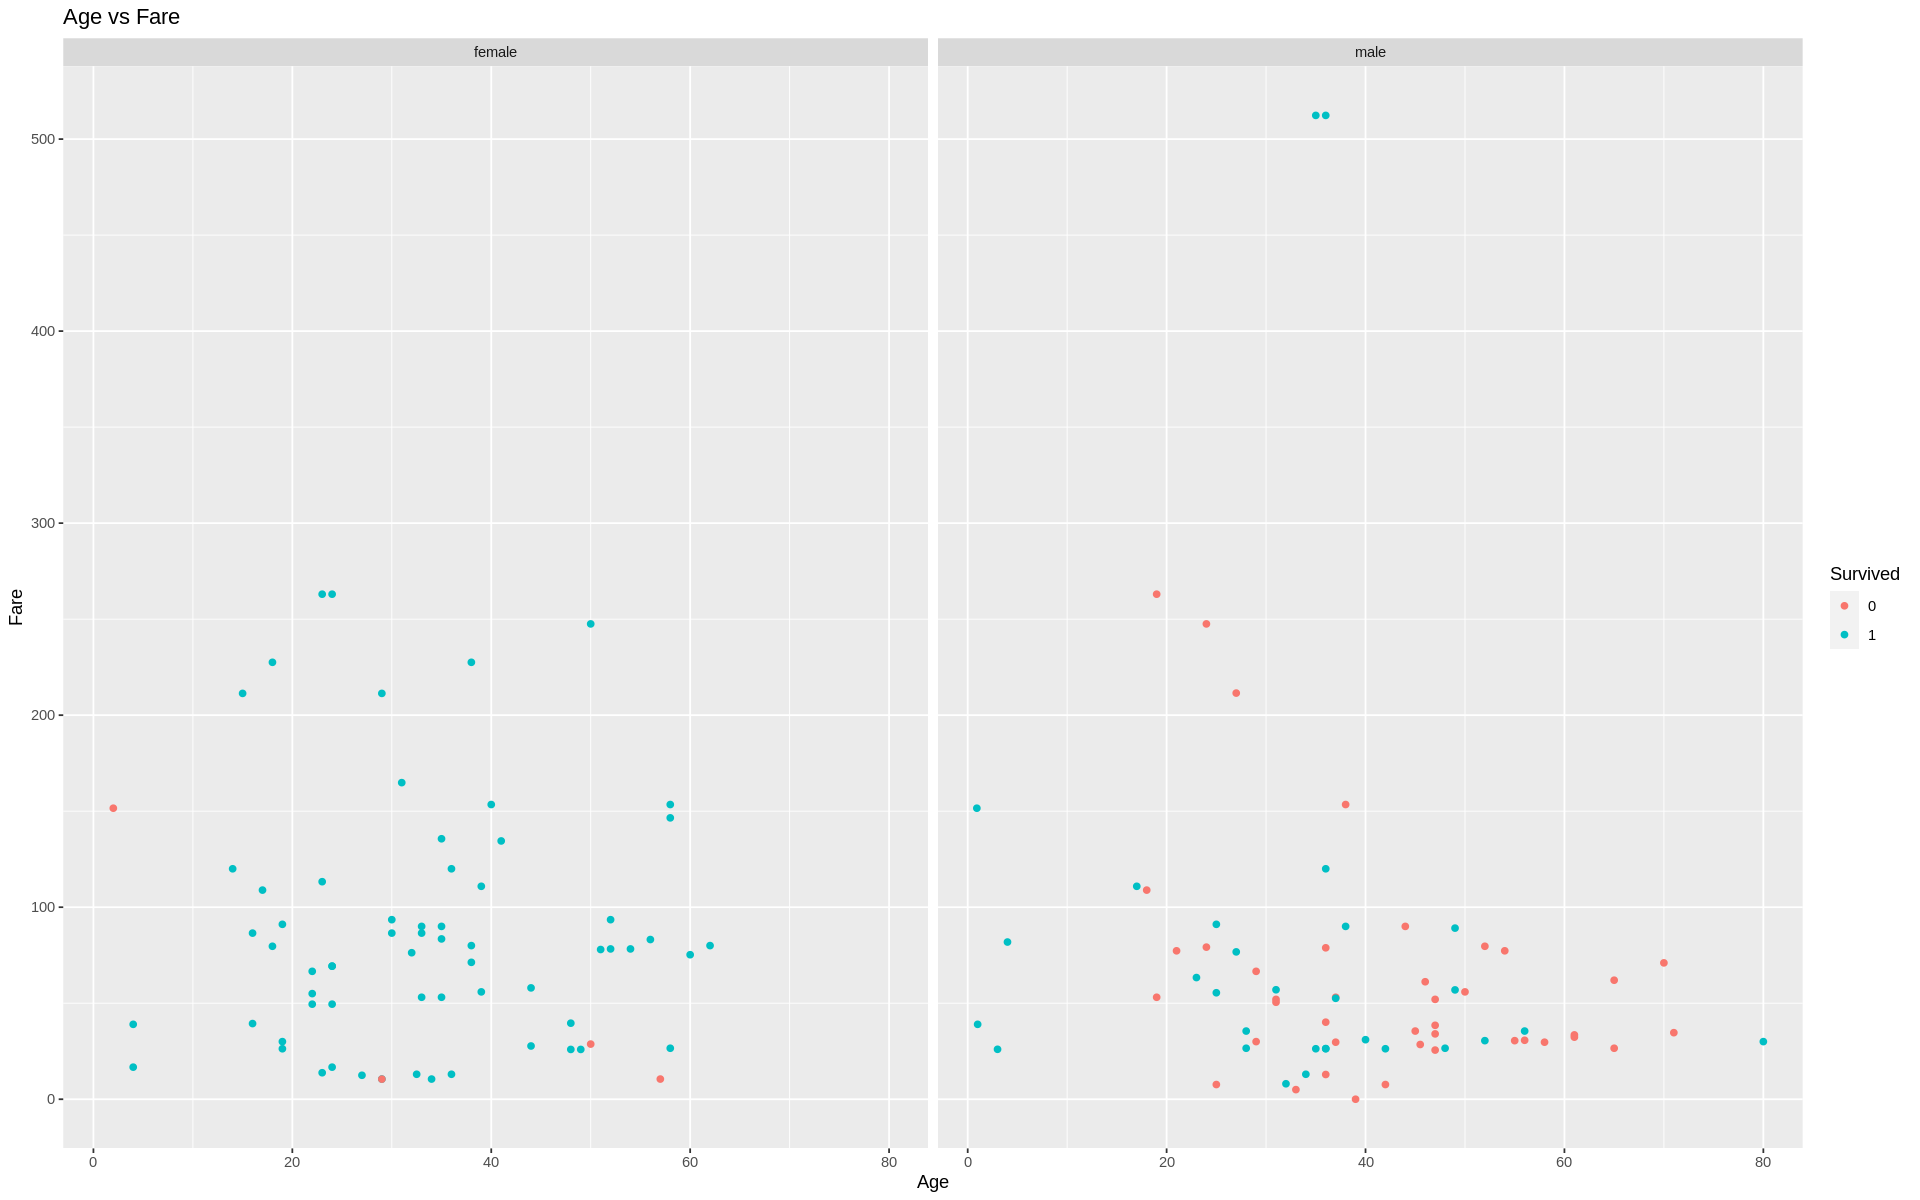

In [115]:
#Graph "Age vs Fare" 
set.seed(1)
options(repr.plot.width = 16, repr.plot.height = 10)

titanic_plot <- titanic_train %>%
    ggplot(aes(x = Age, y = Fare, color = Survived)) +
    geom_point() +
    facet_grid(~Sex) +
    labs(x = "Age", y = "Fare", title = "Age vs Fare", color ="Survived")
titanic_plot


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.6978836,5,0.01791632,Model09


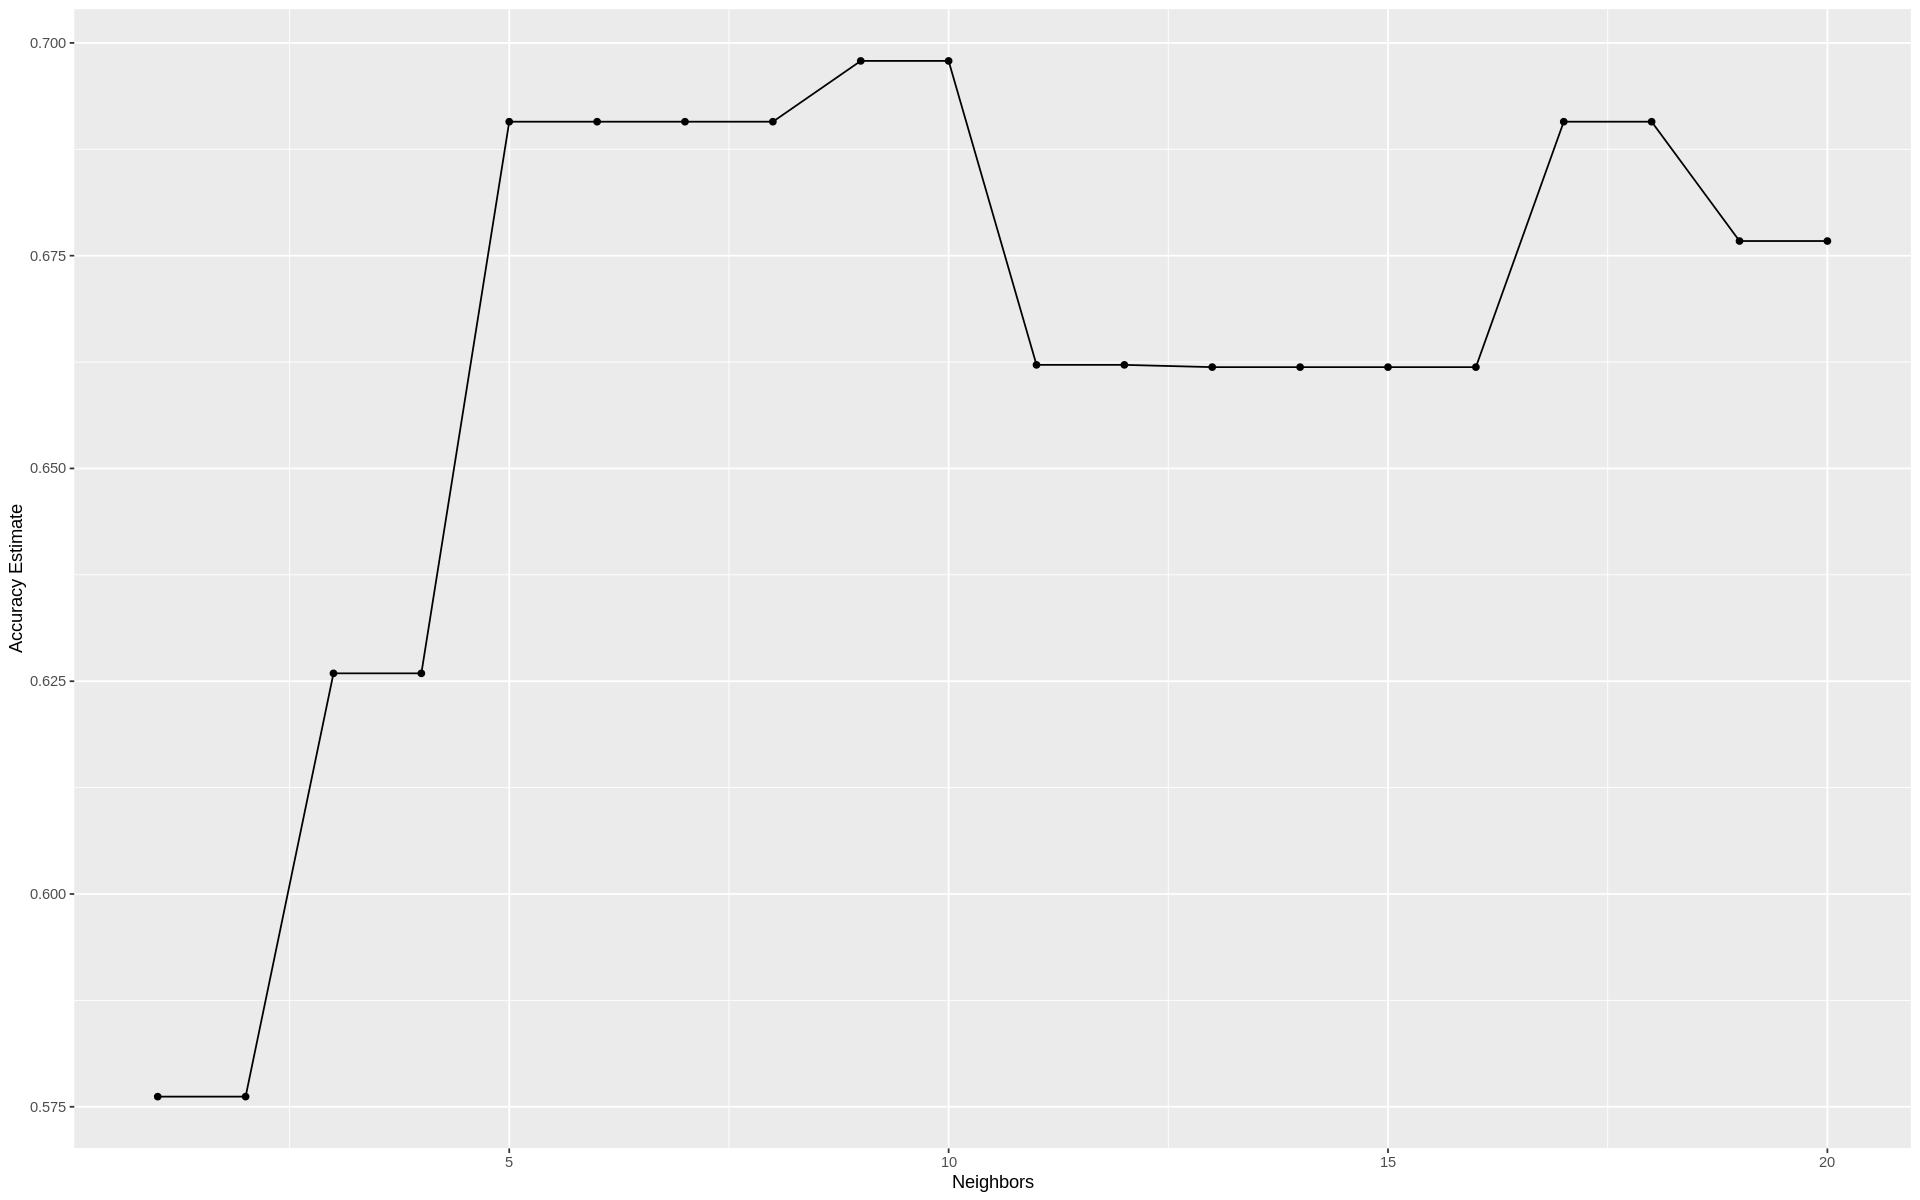

In [116]:
# Classification
# Cross-validation (find k value)
set.seed(1)
titanic_recipe <- recipe(Survived ~ Age + Fare, data = titanic_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

titanic_vfold <- vfold_cv(titanic_train, v = 5, strata = Survived)

gridvals <- tibble(neighbors = seq(from = 1, to = 20))

titanic_results <- workflow() %>%
    add_recipe(titanic_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = titanic_vfold, grid = gridvals) %>%
    collect_metrics()

accuracies <- titanic_results %>%
    filter(.metric == "accuracy")

k <- accuracies %>%
    filter(mean == max(mean)) %>%
    head(n=1)
k

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k

In [117]:
# Using train data to build classifier
# calculating accuracy
set.seed(1)

k_max <- k %>%
    pull(neighbors)

knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = k_max) %>%
    set_engine("kknn") %>%
    set_mode("classification")

titanic_best_fit <- workflow() %>%
    add_recipe(titanic_recipe) %>%
    add_model(knn_best) %>%
    fit(data = titanic_train) 

titanic_predictions <- predict(titanic_best_fit, titanic_test) %>%
    bind_cols(titanic_test) %>%
    metrics(truth = Survived, estimate = .pred_class)
titanic_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.630434783
kap,binary,0.005089059


The estimated accuracy of this classifier on test data was 63 present. Those of two predictor variables (age and fare) are strong relationship between predictor vaiables and survived in titanic. The result showed that pressentages with higher fares and younger age were probably more likely to survive, which is the same as expected. 